In [3]:
!pip install mlxtend -qq
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels
from scipy import stats
import statsmodels.api as sm
from scipy.stats import shapiro
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import Lasso, Ridge, ElasticNet, SGDRegressor, LinearRegression
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV, cross_val_score, train_test_split

%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.float_format = '{:.6f}'.format
data = pd.read_csv("CO2 Emissions_Canada.csv")

data.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.000000,4,AS5,Z,9.900000,6.700000,8.500000,33,196
1,ACURA,ILX,COMPACT,2.400000,4,M6,Z,11.200000,7.700000,9.600000,29,221
2,ACURA,ILX HYBRID,COMPACT,1.500000,4,AV7,Z,6.000000,5.800000,5.900000,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.500000,6,AS6,Z,12.700000,9.100000,11.100000,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.500000,6,AS6,Z,12.100000,8.700000,10.600000,27,244


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

In [6]:
data = data.rename(columns={
    'Vehicle Class': 'Vehicle_Class',
    'Engine Size(L)': 'Engine_Size',
    'Fuel Type': 'Fuel_Type',
    'Fuel Consumption City (L/100 km)': 'Fuel_Consumption_City',
    'Fuel Consumption Hwy (L/100 km)': 'Fuel_Consumption_Hwy',
    'Fuel Consumption Comb (L/100 km)': 'Fuel_Consumption_Comb',
    'Fuel Consumption Comb (mpg)': 'Fuel_Consumption_Comb1',
    'CO2 Emissions(g/km)': 'CO2_Emissions'
})
data.shape

(7385, 12)

In [7]:
data.dtypes

,0
Make,object
Model,object
Vehicle_Class,object
Engine_Size,float64
Cylinders,int64
Transmission,object
Fuel_Type,object
Fuel_Consumption_City,float64
Fuel_Consumption_Hwy,float64
Fuel_Consumption_Comb,float64


In [8]:
duplicate = data.duplicated().sum()
print('There are {} duplicated rows in the data'.format(duplicate))
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True, drop=True)

There are 1103 duplicated rows in the data


In [9]:
data.describe(include=np.number)

,Engine_Size,Cylinders,Fuel_Consumption_City,Fuel_Consumption_Hwy,Fuel_Consumption_Comb,Fuel_Consumption_Comb1,CO2_Emissions
count,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000
mean,3.161812,5.618911,12.610220,9.070583,11.017876,27.411016,251.157752
std,1.365201,1.846250,3.553066,2.278884,2.946876,7.245318,59.290426
min,0.900000,3.000000,4.200000,4.000000,4.100000,11.000000,96.000000
25%,2.000000,4.000000,10.100000,7.500000,8.900000,22.000000,208.000000
50%,3.000000,6.000000,12.100000,8.700000,10.600000,27.000000,246.000000
75%,3.700000,6.000000,14.700000,10.300000,12.700000,32.000000,289.000000
max,8.400000,16.000000,30.600000,20.600000,26.100000,69.000000,522.000000


In [10]:
data.describe(include = object)

,Make,Model,Vehicle_Class,Transmission,Fuel_Type
count,6282,6282,6282,6282,6282
unique,42,2053,16,27,5
top,FORD,F-150 FFV,SUV - SMALL,AS6,X
freq,577,32,1006,1139,3039


In [11]:
data_num_features = data.select_dtypes(include=np.number)

print('The numerical columns in the dataset are: ',data_num_features.columns)

The numerical columns in the dataset are:  Index(['Engine_Size', 'Cylinders', 'Fuel_Consumption_City',
       'Fuel_Consumption_Hwy', 'Fuel_Consumption_Comb',
       'Fuel_Consumption_Comb1', 'CO2_Emissions'],
      dtype='object')


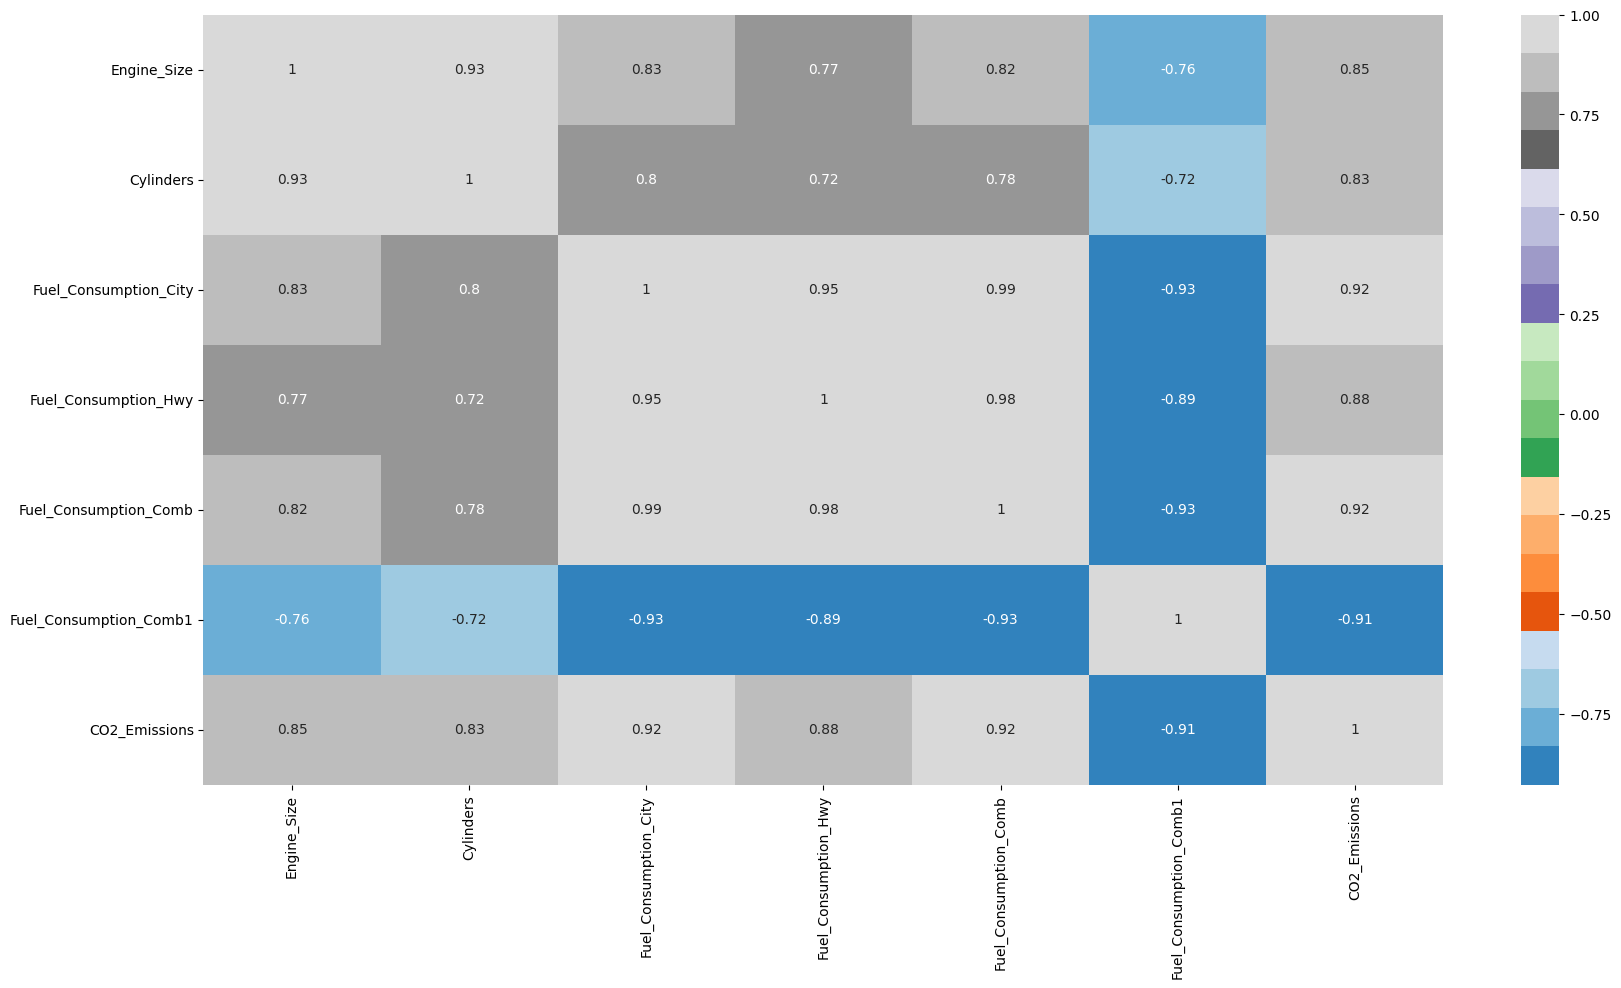

In [12]:
plt.figure(figsize=(20,10))

corr =  data_num_features.corr()

corr =data_num_features.corr(method='pearson')
sns.heatmap(corr, annot=True,cmap='tab20c')
plt.show()

The numerical columns in the dataset are:  Index(['Engine_Size', 'Cylinders', 'Fuel_Consumption_City',
       'Fuel_Consumption_Hwy', 'Fuel_Consumption_Comb',
       'Fuel_Consumption_Comb1', 'CO2_Emissions'],
      dtype='object')


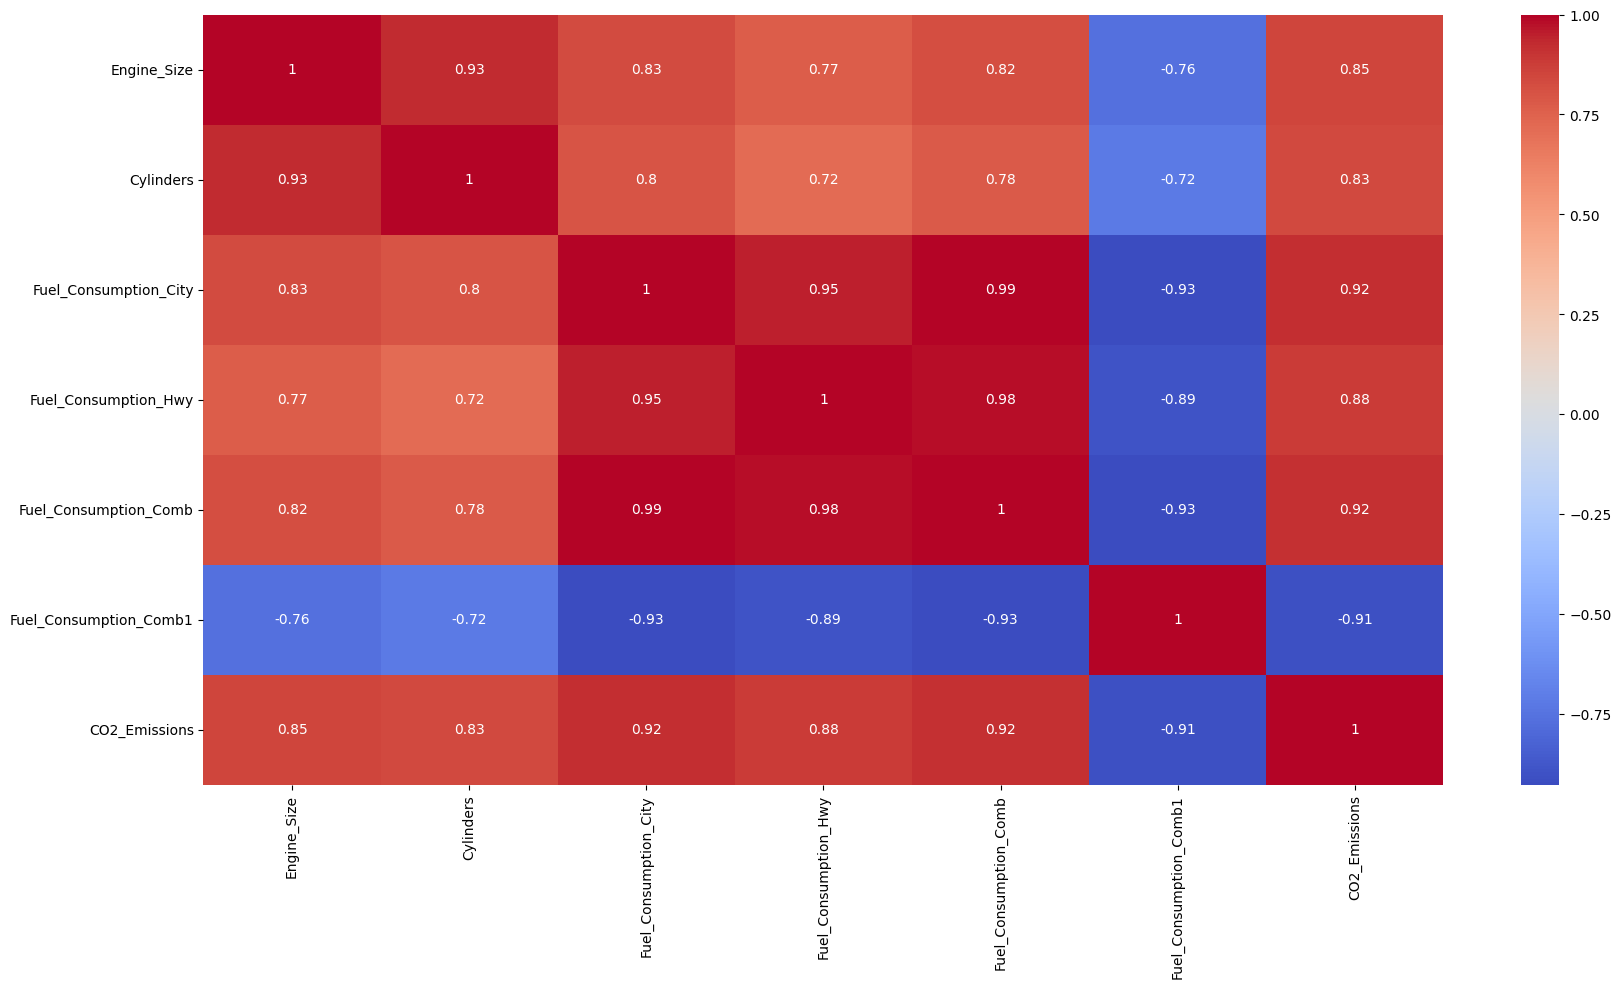

In [13]:
data_num_features = data.select_dtypes(include=np.number)

print('The numerical columns in the dataset are: ',data_num_features.columns)
plt.figure(figsize=(20,10))

corr =  data_num_features.corr()

corr =data_num_features.corr(method='pearson')
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

In [14]:
data_cat_features = data.select_dtypes(include='object')
data_cat_features1 = data_cat_features[['Vehicle_Class', 'Transmission', 'Fuel_Type', 'Model','Make']]

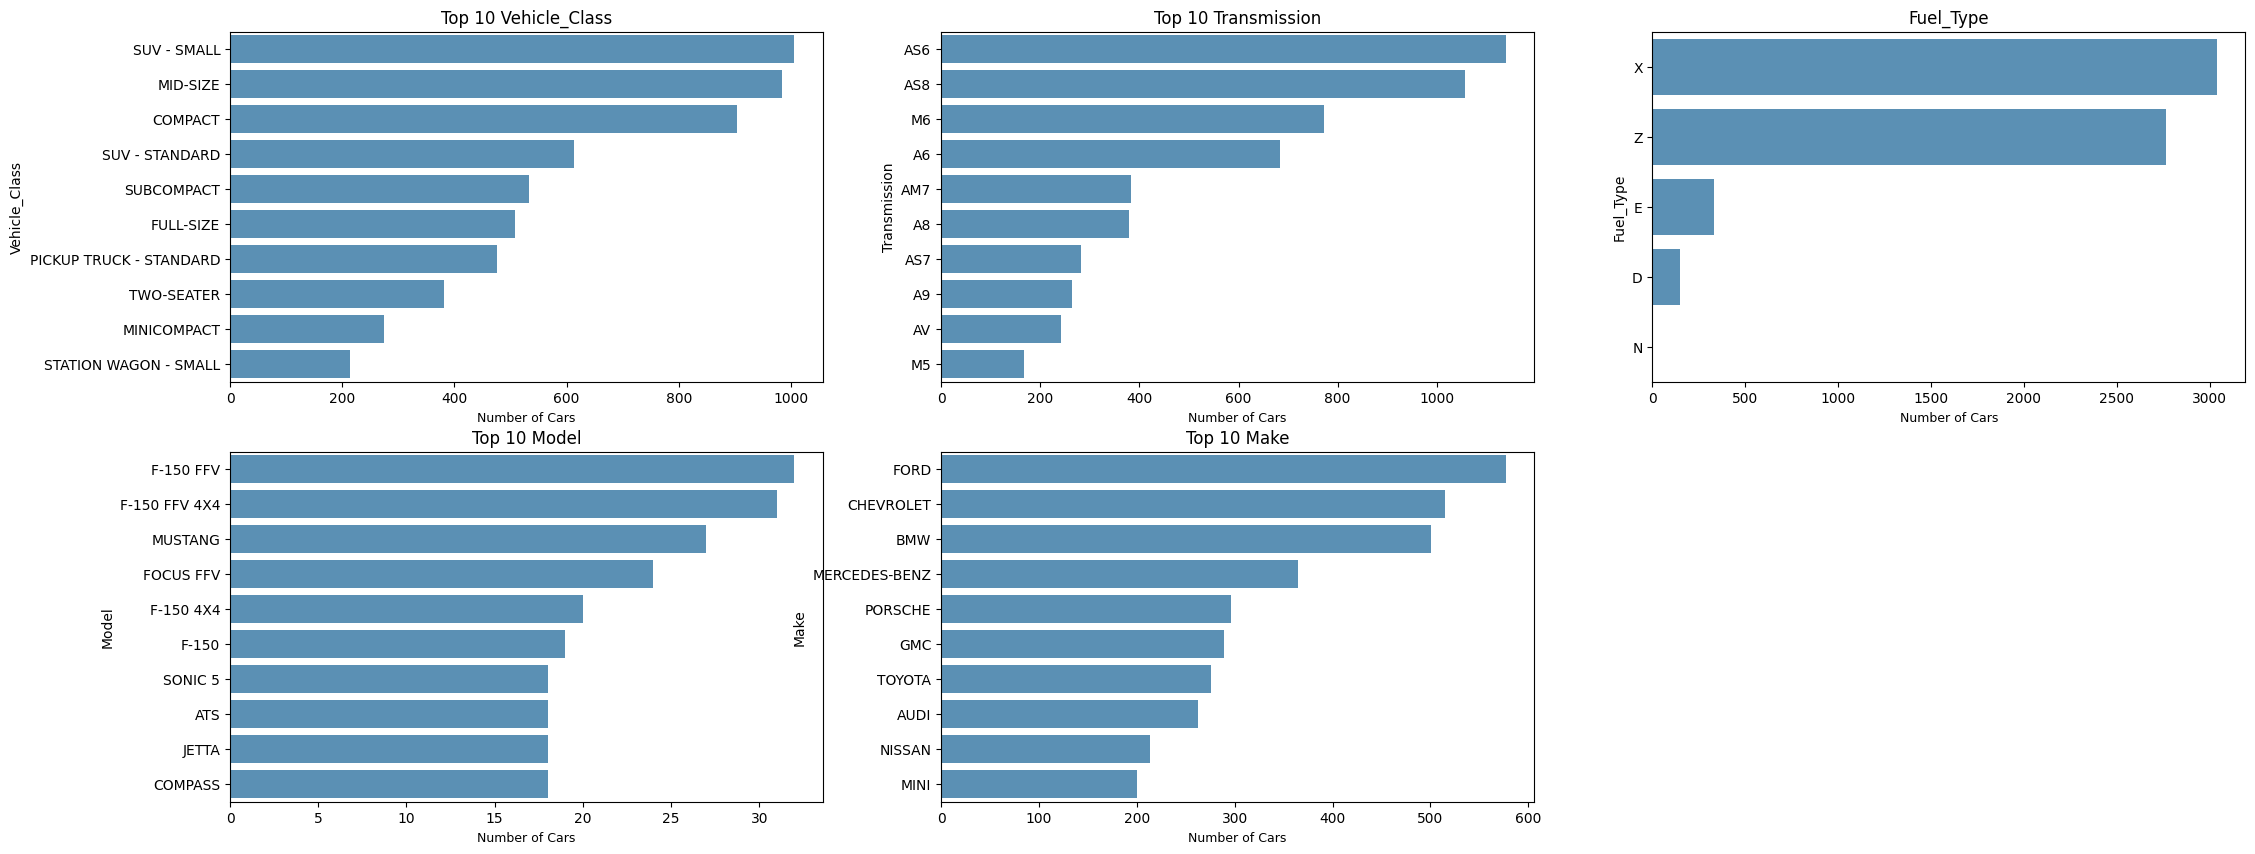

In [15]:
fig,ax= plt.subplots(nrows=2,ncols=3,figsize=(26, 10))

for variable, subplot in zip(data_cat_features1.columns,ax.flatten()):
    cat_count  = data[variable].value_counts()
    cat_count10 = cat_count[:10,]
    z = sns.barplot(x=cat_count10.values, y=cat_count10.index, alpha=0.8, ax=subplot)
    if cat_count.size > 10:
        z.set_title('Top 10 {}'.format(variable))
    else:
        z.set_title(variable)
    z.set_xlabel('Number of Cars', fontsize=9)

fig.delaxes(ax[1][2])

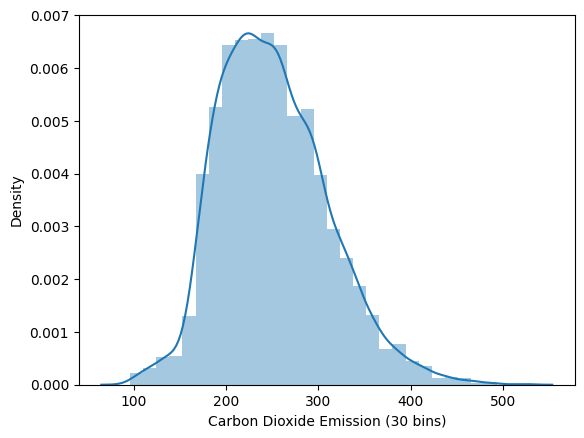

In [16]:
sns.distplot(data['CO2_Emissions'], bins=30, kde=True, axlabel='Carbon Dioxide Emission (30 bins)')
plt.show()

In [17]:
mean = data['CO2_Emissions'].mean()
mode = data['CO2_Emissions'].mode()
median = data['CO2_Emissions'].median()

print(f'Mean for CO2 Emission is {mean}')
print(f'Median for CO2 Emission is {median}')
print(f'Mode for CO2 Emission is {mode}')

Mean for CO2 Emission is 251.1577523081821
Median for CO2 Emission is 246.0
Mode for CO2 Emission is 0    221
1    246
Name: CO2_Emissions, dtype: int64


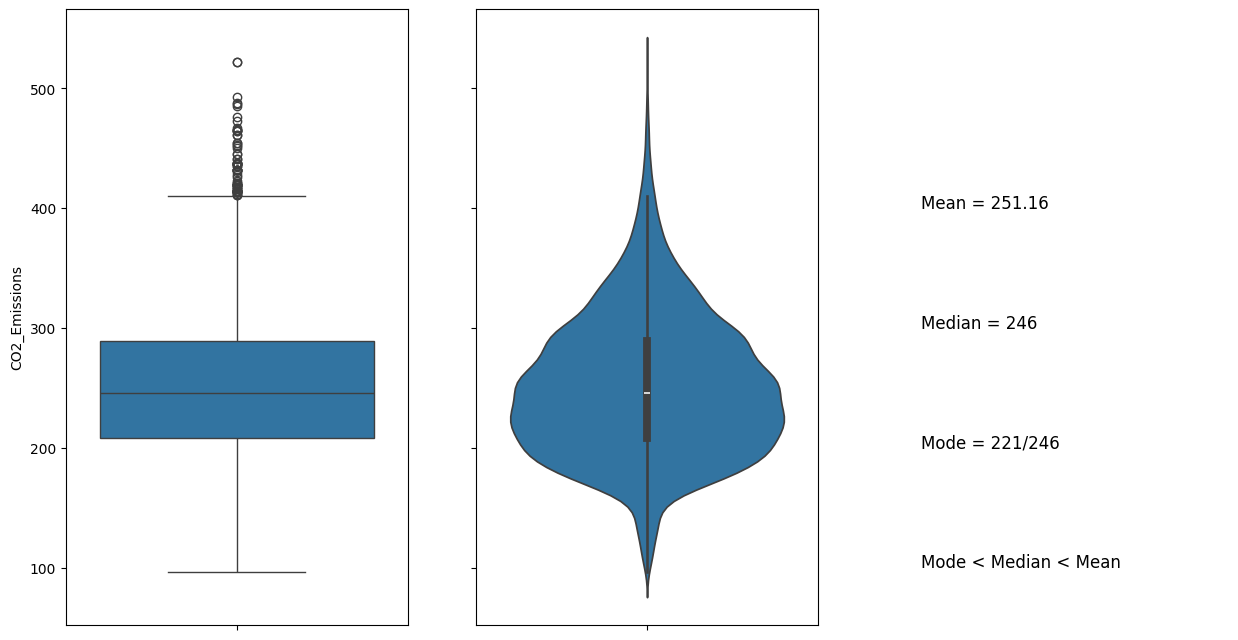

In [18]:
fig, axes = plt.subplots(1,3, sharey=True, figsize=(15,8))
sns.boxplot(y=data['CO2_Emissions'], orient="v", ax = axes[0])
sns.violinplot(y=data['CO2_Emissions'], orient="v", ax = axes[1]);
plt.text(0.1, 200, "Mode = 221/246", fontsize=12)
plt.text(0.1, 300, "Median = 246", fontsize=12)
plt.text(0.1, 400, "Mean = 251.16", fontsize=12)
plt.text(0.1, 100, "Mode < Median < Mean", fontsize=12)
plt.axis("off")
plt.show()

In [19]:
make_co2 = data.groupby('Make')['CO2_Emissions'].mean().sort_values(ascending=False).head(10)
model_co2 = data.groupby('Model')['CO2_Emissions'].mean().sort_values(ascending=False).head(10)
vehicle_class_co2 = data.groupby('Vehicle_Class')['CO2_Emissions'].mean().sort_values(ascending=False).head(10)
transmission_co2 = data.groupby('Transmission')['CO2_Emissions'].mean().sort_values(ascending=False).head(10)
fuel_type_co2 = data.groupby('Fuel_Type')['CO2_Emissions'].mean().sort_values(ascending=False).head()

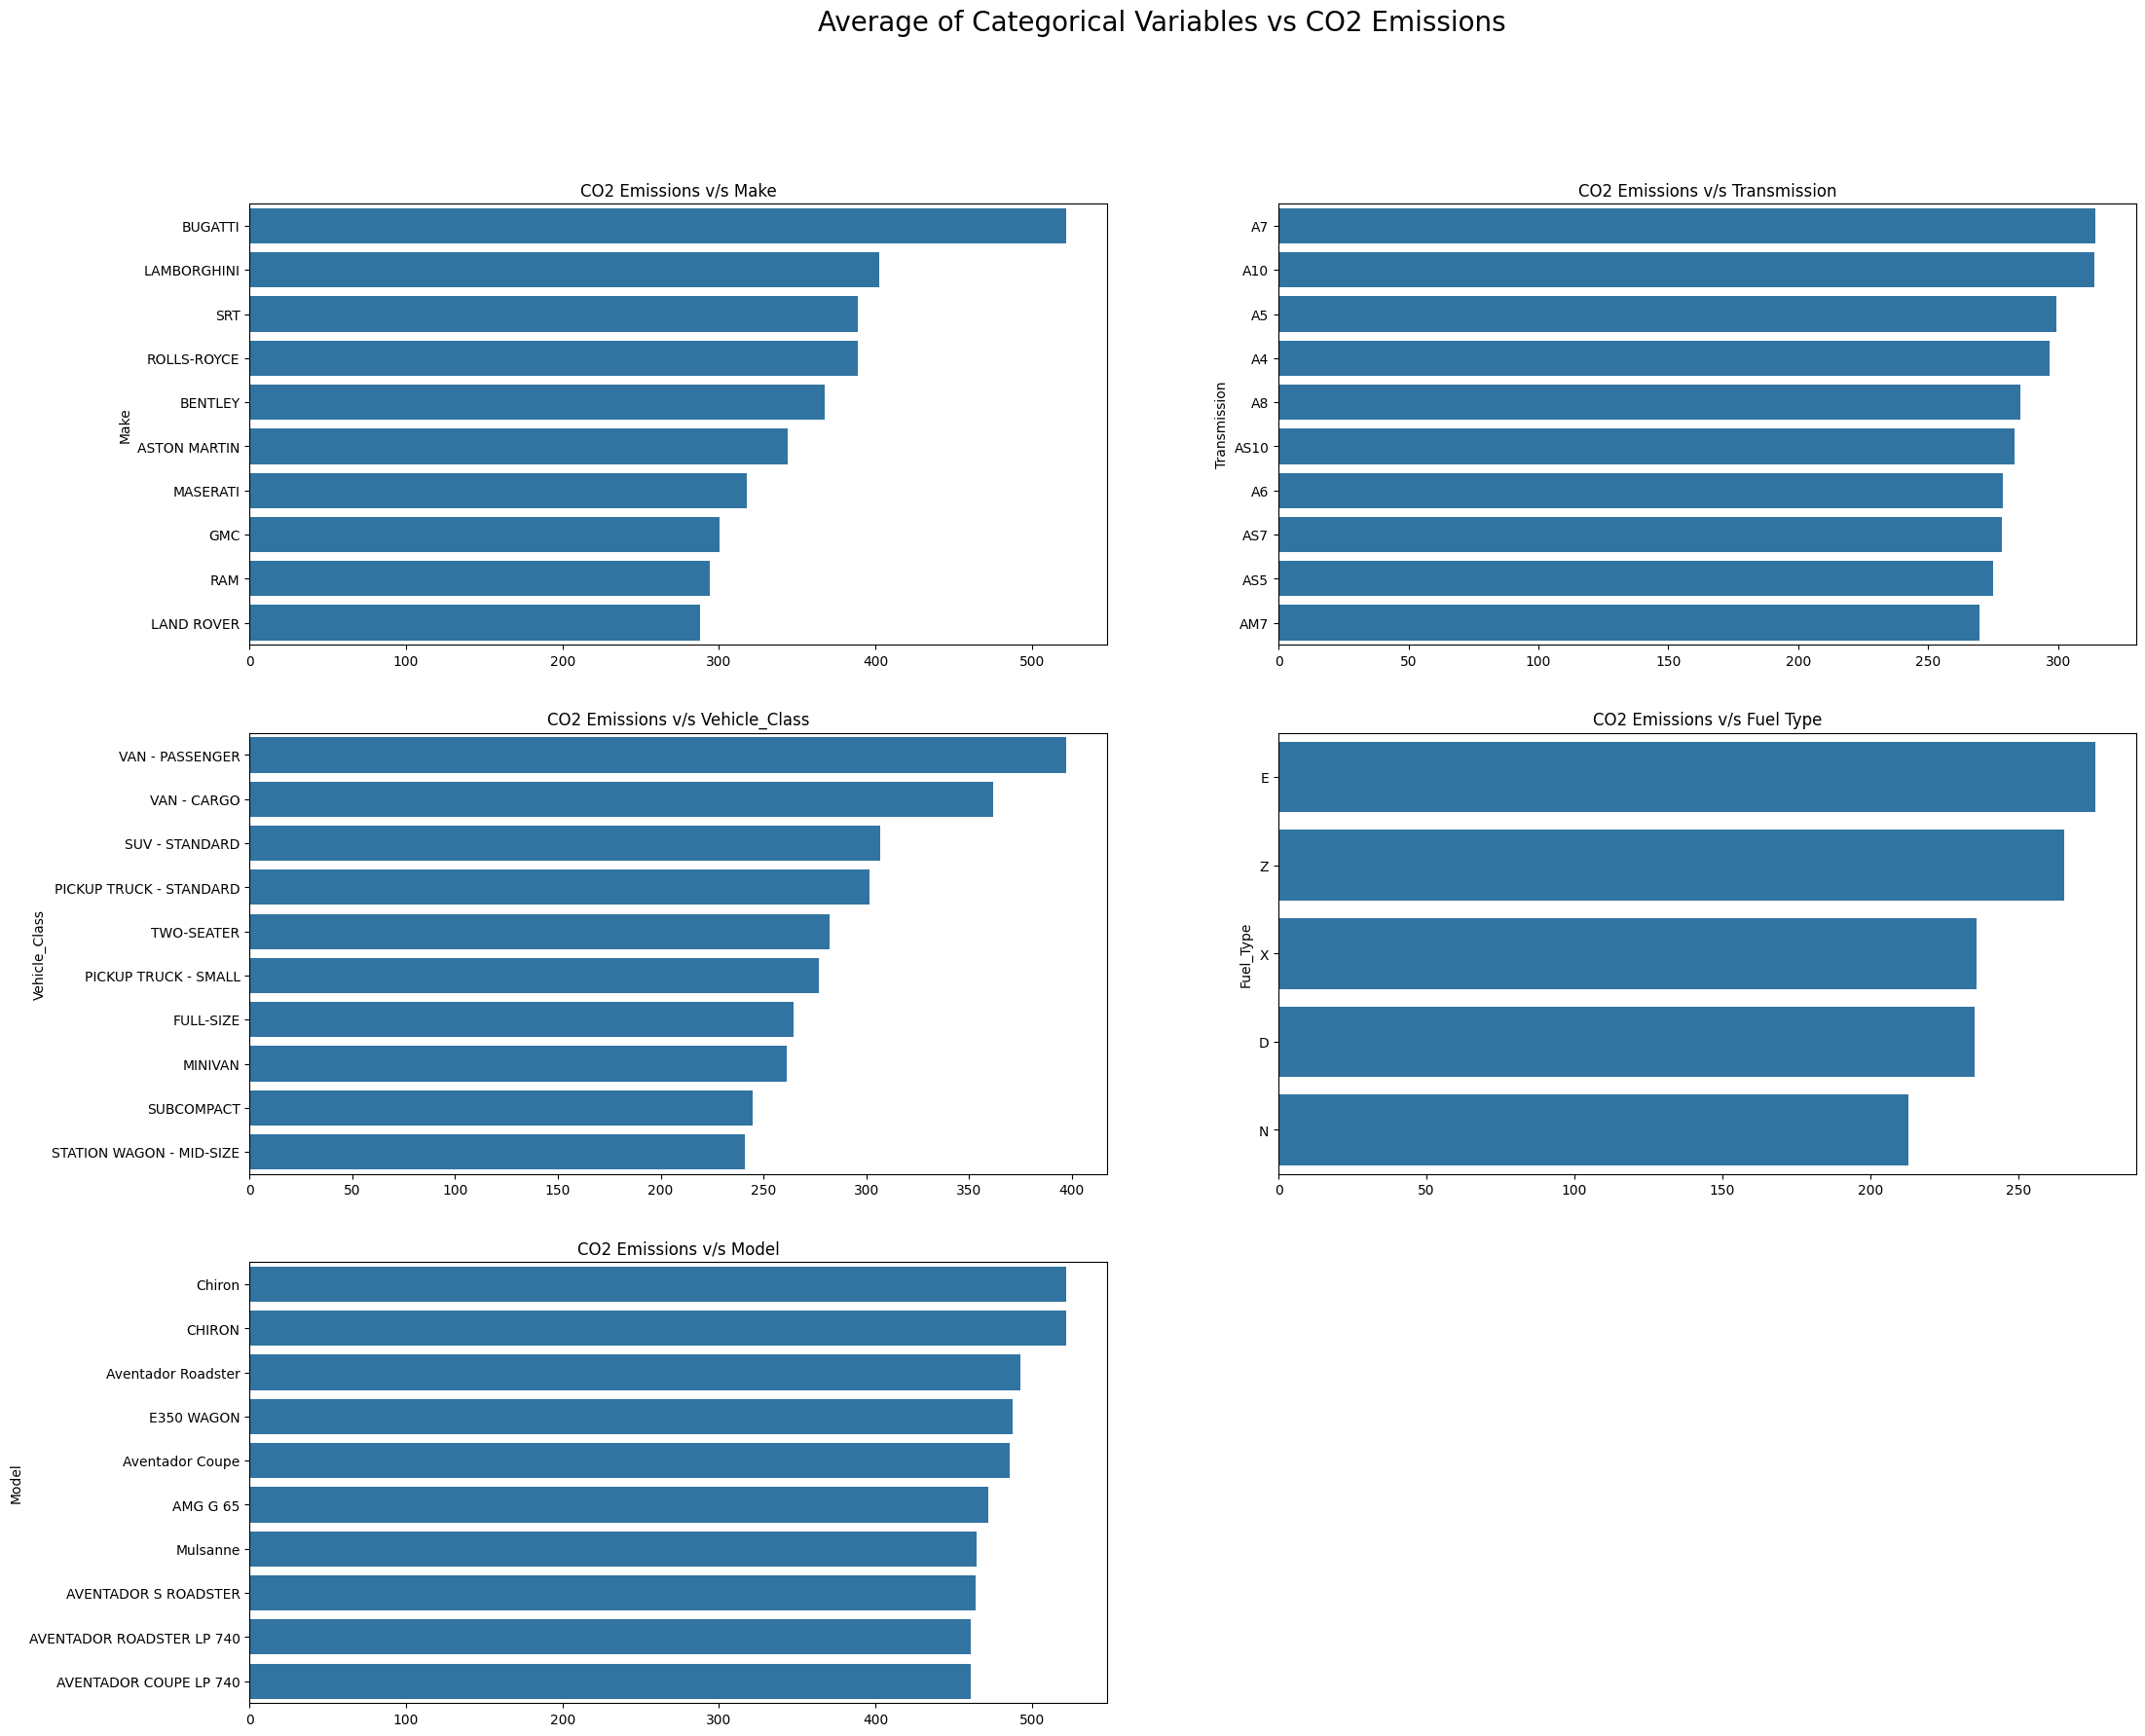

In [20]:
fig, axes = plt.subplots(3,2, figsize=(25,20))
fig.suptitle('Average of Categorical Variables vs CO2 Emissions', size=20)

sns.barplot(ax=axes[0][0],x = make_co2.values,y = make_co2.index)
axes[0][0].set_title('CO2 Emissions v/s Make')

sns.barplot(ax=axes[0][1],x = transmission_co2.values,y = transmission_co2.index)
axes[0][1].set_title('CO2 Emissions v/s Transmission')

sns.barplot(ax=axes[1][0],x = vehicle_class_co2.values,y = vehicle_class_co2.index)
axes[1][0].set_title('CO2 Emissions v/s Vehicle_Class')

sns.barplot(ax=axes[1][1], x=fuel_type_co2.values,y=fuel_type_co2.index)
axes[1][1].set_title('CO2 Emissions v/s Fuel Type')

sns.barplot(ax=axes[2][0],x = model_co2.values,y = model_co2.index)
axes[2][0].set_title('CO2 Emissions v/s Model')


fig.delaxes(axes[2][1])
plt.show()

<Figure size 1000x500 with 0 Axes>

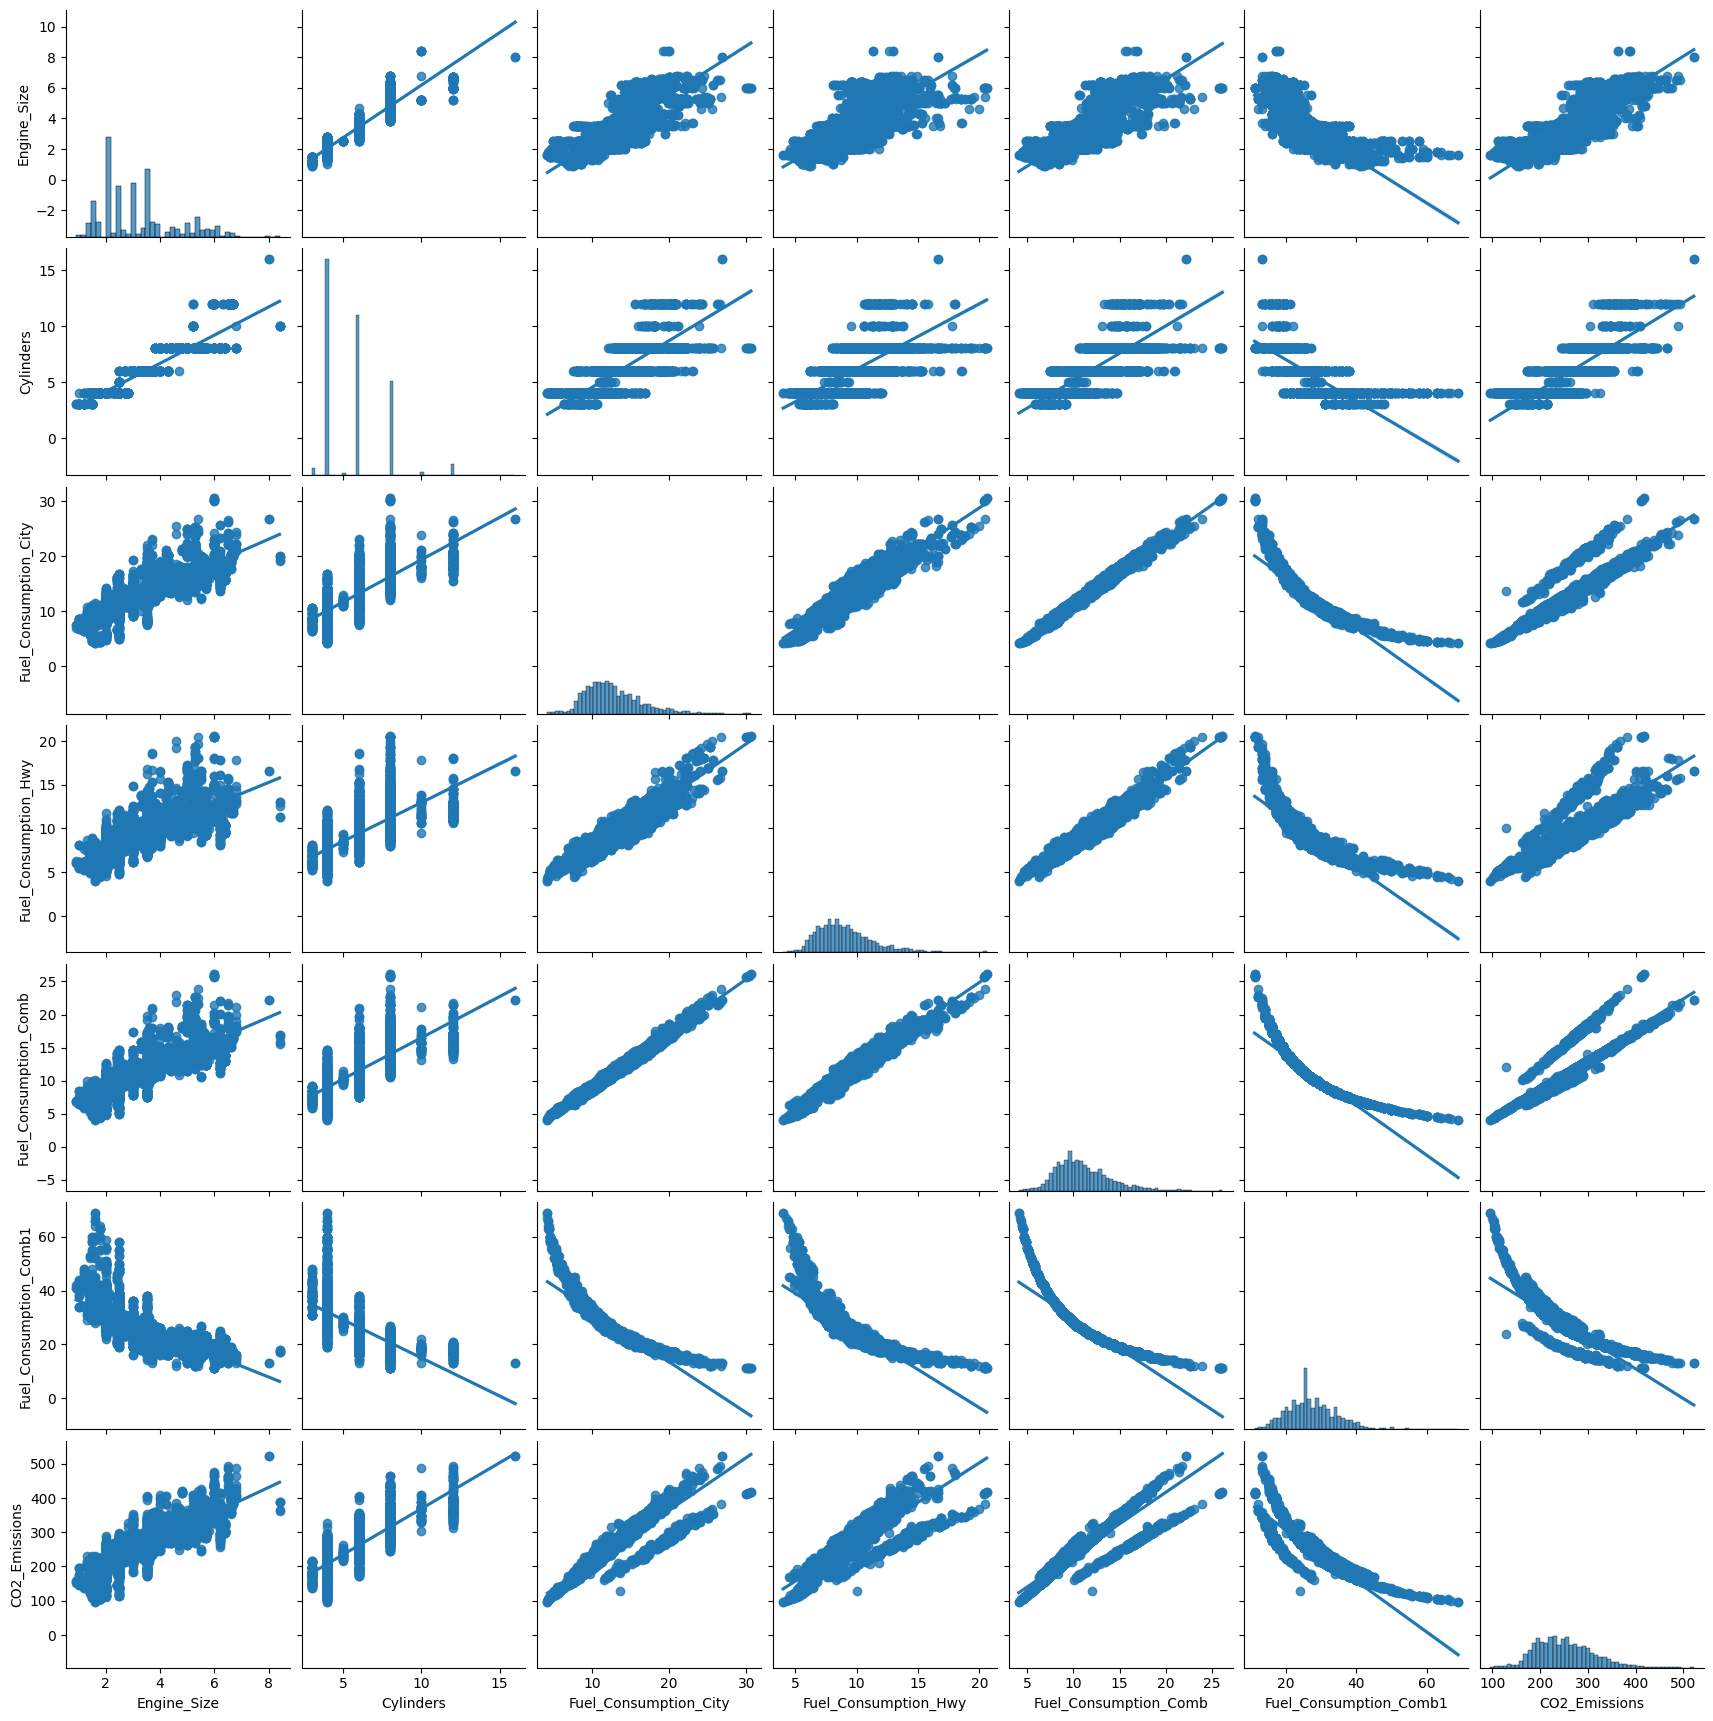

In [21]:
plt.figure(figsize=(10,5))
sns.pairplot(data,kind="reg")
plt.show()

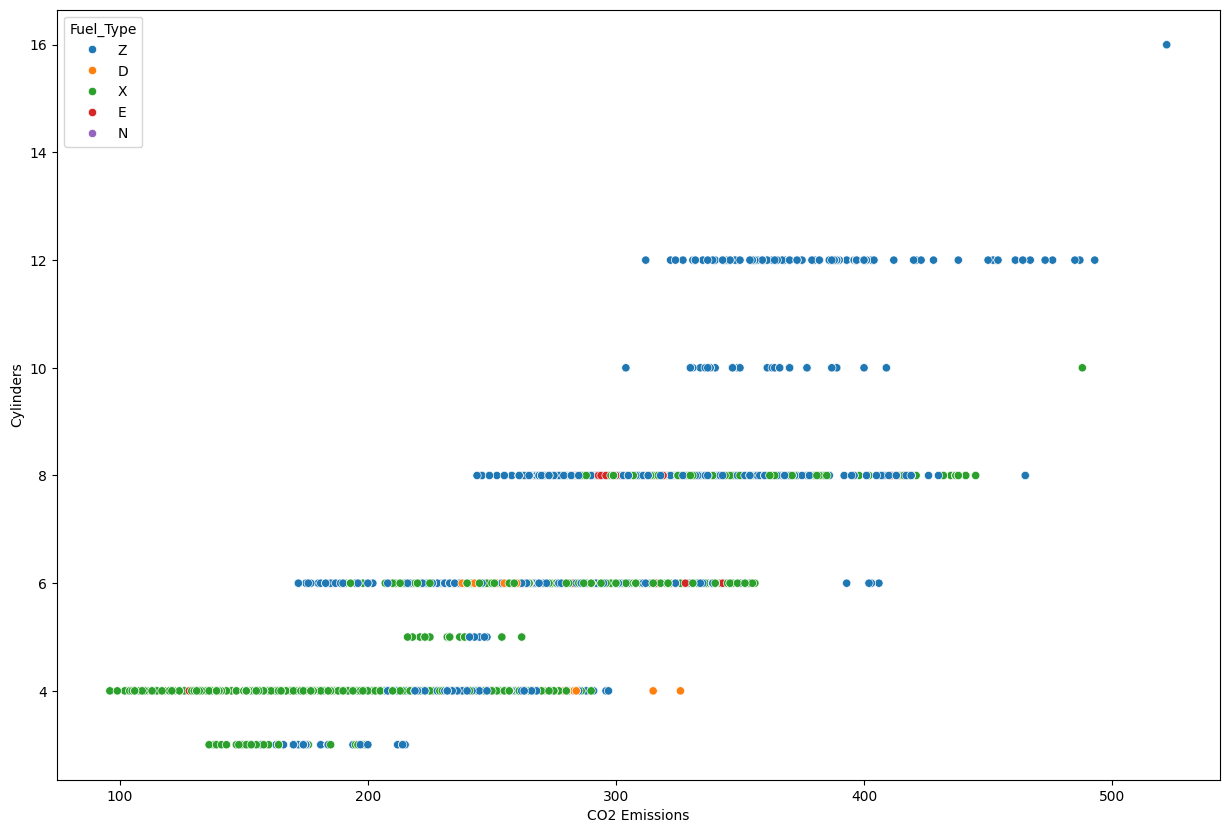

In [22]:
plt.rcParams["figure.figsize"] = (15,10)
sns.scatterplot(x='CO2_Emissions', y='Cylinders', data=data, hue='Fuel_Type')
plt.xlabel("CO2 Emissions", fontsize=10)
plt.ylabel("Cylinders", fontsize=10)
plt.show()

In [23]:
data['Make_Type'] = data['Make'].replace(['BUGATTI', 'PORSCHE', 'MASERATI', 'ASTON MARTIN', 'LAMBORGHINI', 'JAGUAR','SRT'], 'Sports')
data['Make_Type'] = data['Make_Type'].replace(['ALFA ROMEO', 'AUDI', 'BMW', 'BUICK', 'CADILLAC', 'CHRYSLER', 'DODGE', 'GMC','INFINITI', 'JEEP', 'LAND ROVER', 'LEXUS', 'MERCEDES-BENZ','MINI', 'SMART', 'VOLVO'],'Premium')
data['Make_Type'] = data['Make_Type'].replace(['ACURA', 'BENTLEY', 'LINCOLN', 'ROLLS-ROYCE',  'GENESIS'], 'Luxury')
data['Make_Type'] = data['Make_Type'].replace(['CHEVROLET', 'FIAT', 'FORD', 'KIA', 'HONDA', 'HYUNDAI', 'MAZDA', 'MITSUBISHI','NISSAN', 'RAM', 'SCION', 'SUBARU', 'TOYOTA','VOLKSWAGEN'],'General')
data.drop(['Make'], inplace=True, axis=1)

data['Make_Type'].unique()

array(['Luxury', 'Premium', 'Sports', 'General'], dtype=object)

In [24]:
data['Make_Type'].value_counts()

,count
Make_Type,
General,2776
Premium,2731
Sports,546
Luxury,229


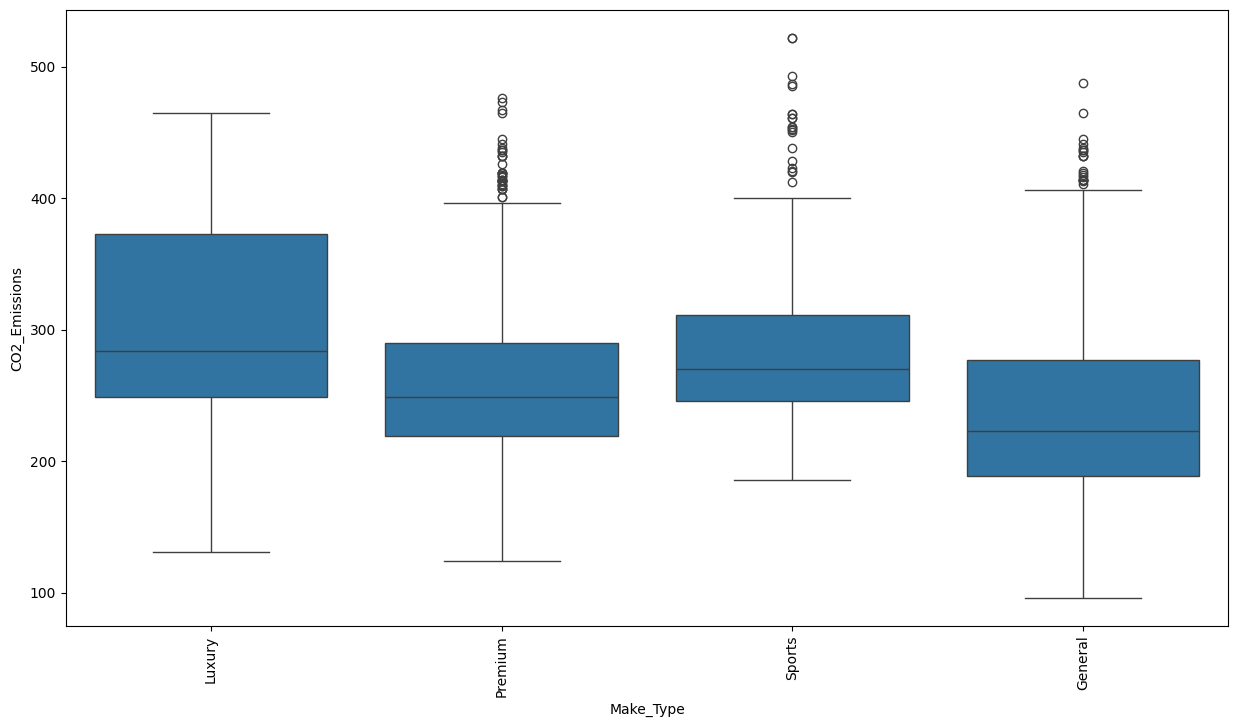

In [25]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Make_Type", y="CO2_Emissions", data=data)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
plt.show()

In [26]:
data['Vehicle_Class_Type'] = data['Vehicle_Class'].replace(['COMPACT', 'MINICOMPACT', 'SUBCOMPACT'], 'Hatchback')
data['Vehicle_Class_Type'] = data['Vehicle_Class_Type'].replace(['MID-SIZE', 'TWO-SEATER', 'FULL-SIZE', 'STATION WAGON - SMALL', 'STATION WAGON - MID-SIZE'],'Sedan')
data['Vehicle_Class_Type'] = data['Vehicle_Class_Type'].replace(['SUV - SMALL', 'SUV - STANDARD', 'MINIVAN'],  'SUV')
data['Vehicle_Class_Type'] = data['Vehicle_Class_Type'].replace(['VAN - CARGO', 'VAN - PASSENGER', 'PICKUP TRUCK - STANDARD', 'SPECIAL PURPOSE VEHICLE', 'PICKUP TRUCK - SMALL'], 'Truck')
data.drop(['Vehicle_Class'], inplace=True,  axis=1)

data['Vehicle_Class_Type'].unique()

array(['Hatchback', 'SUV', 'Sedan', 'Truck'], dtype=object)

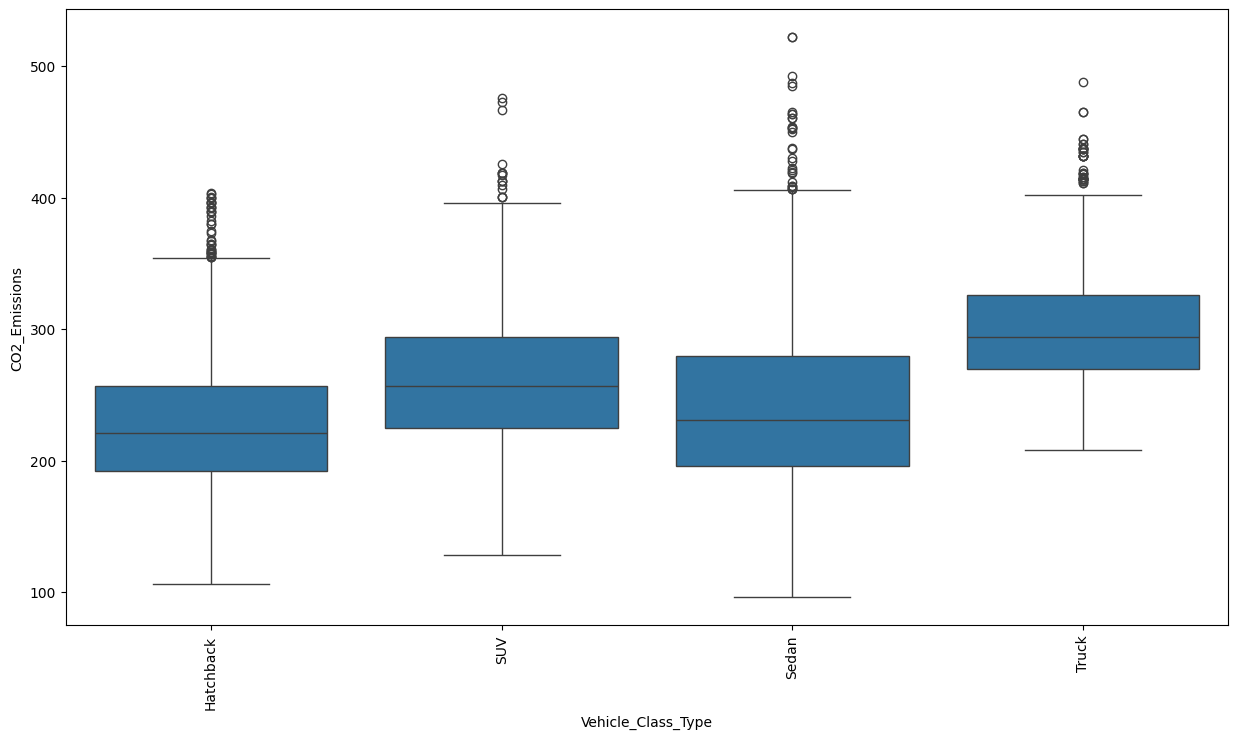

In [27]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Vehicle_Class_Type", y="CO2_Emissions", data=data)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
plt.show()

In [28]:
data.drop(['Model'],axis=1,inplace=True)

In [29]:
df_num_features=data.select_dtypes(include=np.number)
Q1 = df_num_features.quantile(0.25)
Q3 = df_num_features.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
outlier = pd.DataFrame((df_num_features < (Q1 - 1.5 * IQR)) | (df_num_features > (Q3 + 1.5 * IQR)))

for i in outlier.columns:
    print('Total number of Outliers in column {} are {}'.format(i, (len(outlier[outlier[i] == True][i]))))

Engine_Size               1.700000
Cylinders                 2.000000
Fuel_Consumption_City     4.600000
Fuel_Consumption_Hwy      2.800000
Fuel_Consumption_Comb     3.800000
Fuel_Consumption_Comb1   10.000000
CO2_Emissions            81.000000
dtype: float64
Total number of Outliers in column Engine_Size are 121
Total number of Outliers in column Cylinders are 177
Total number of Outliers in column Fuel_Consumption_City are 116
Total number of Outliers in column Fuel_Consumption_Hwy are 150
Total number of Outliers in column Fuel_Consumption_Comb are 115
Total number of Outliers in column Fuel_Consumption_Comb1 are 95
Total number of Outliers in column CO2_Emissions are 74


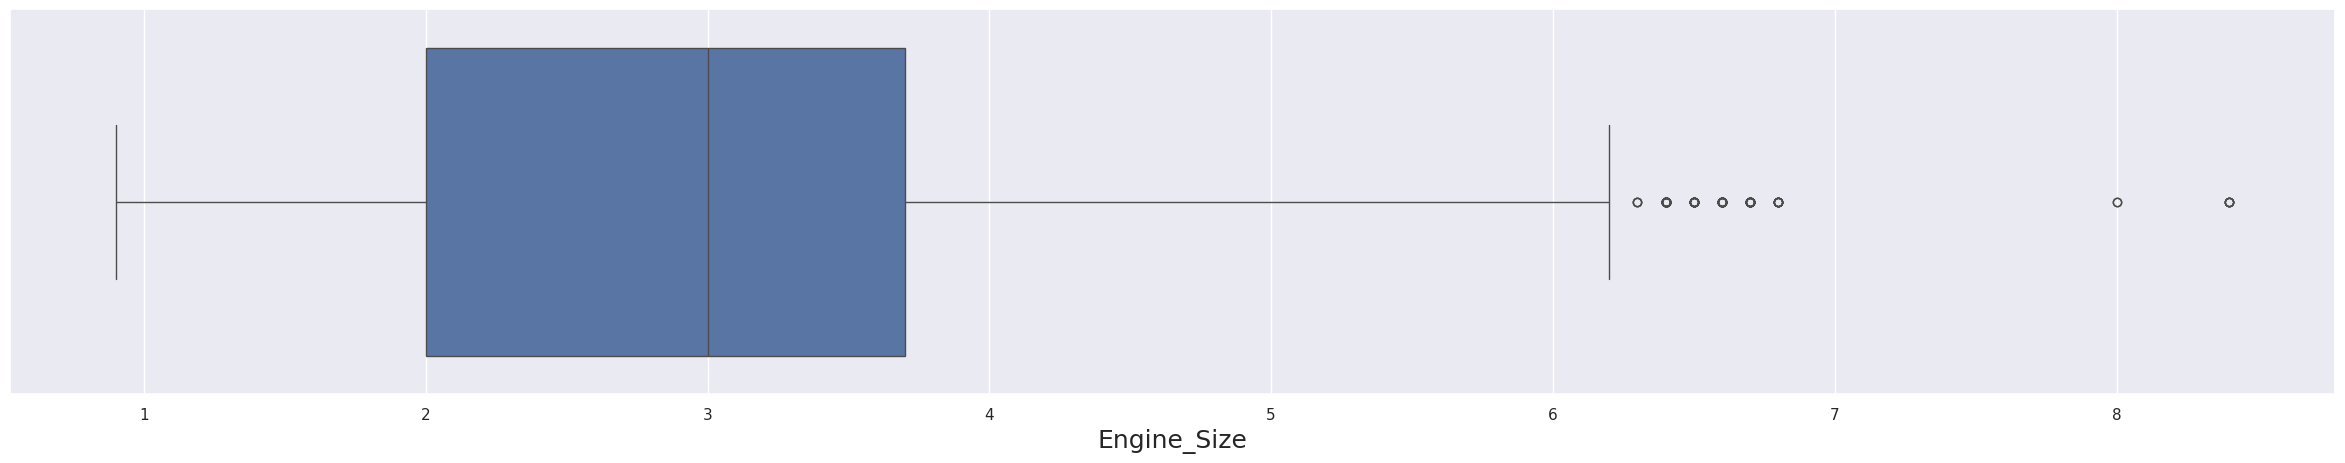

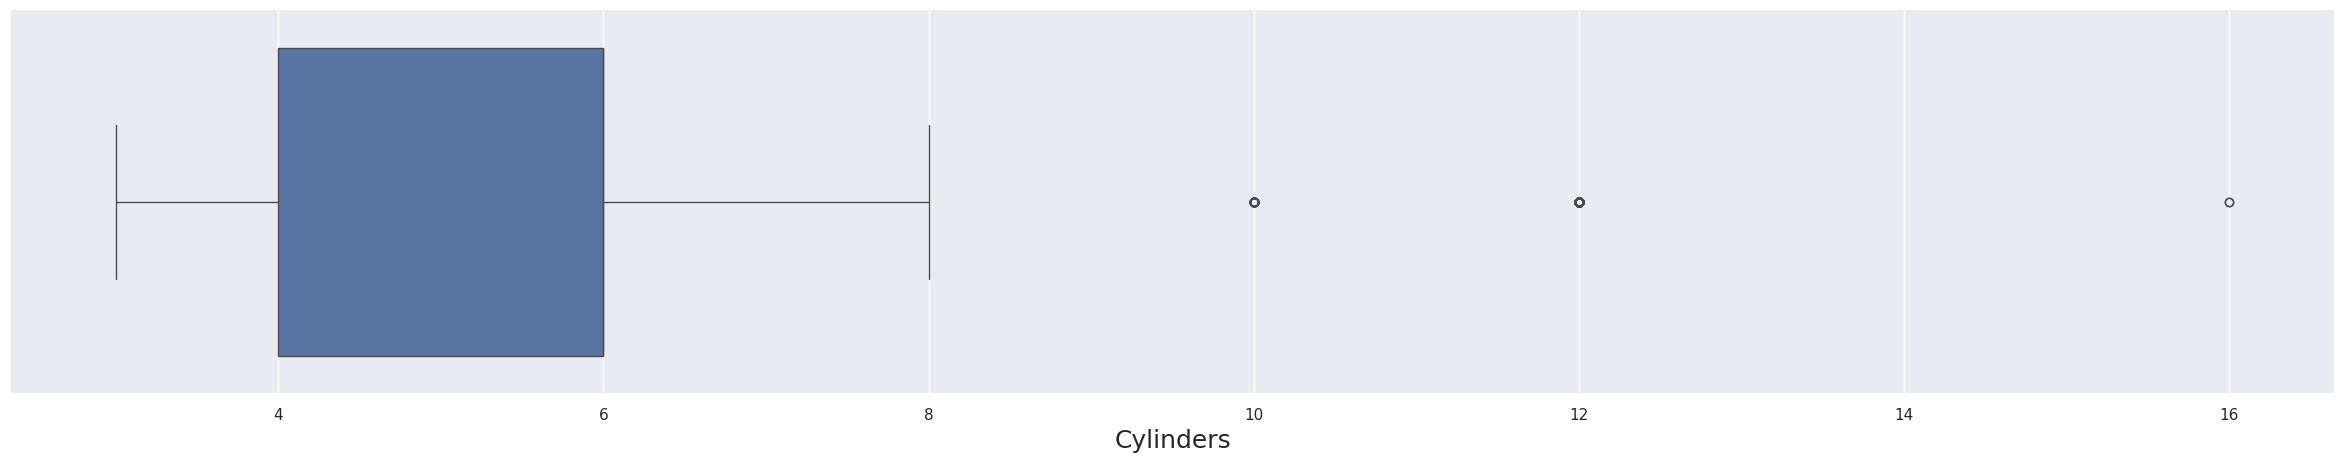

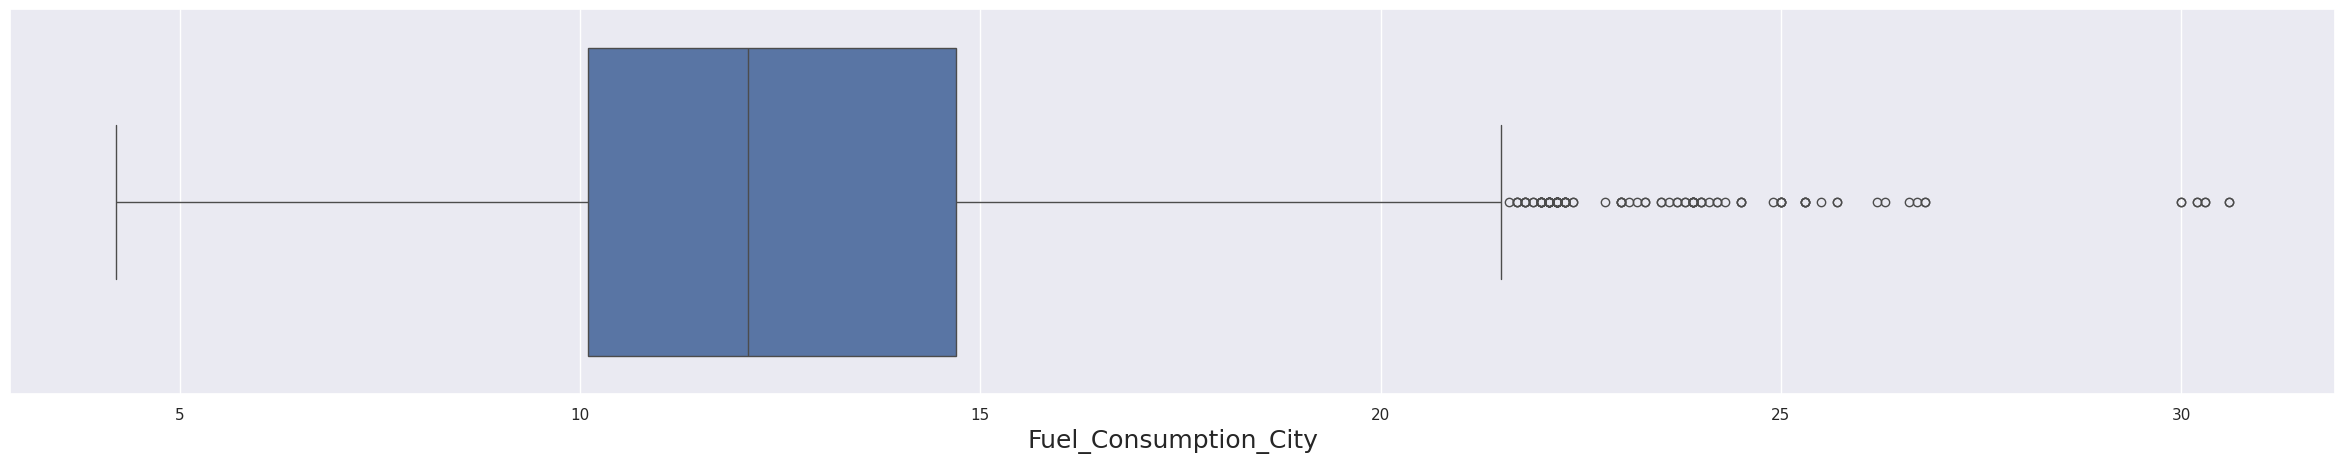

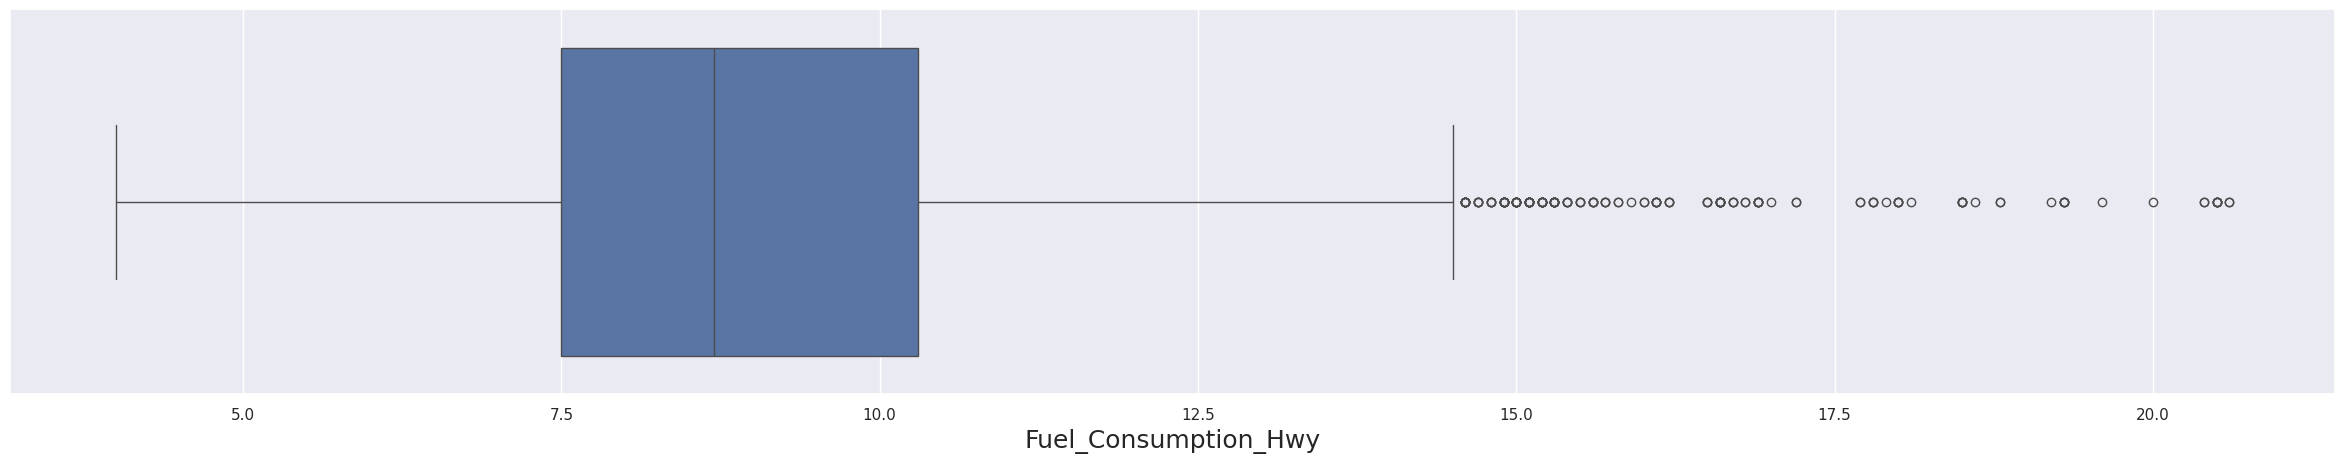

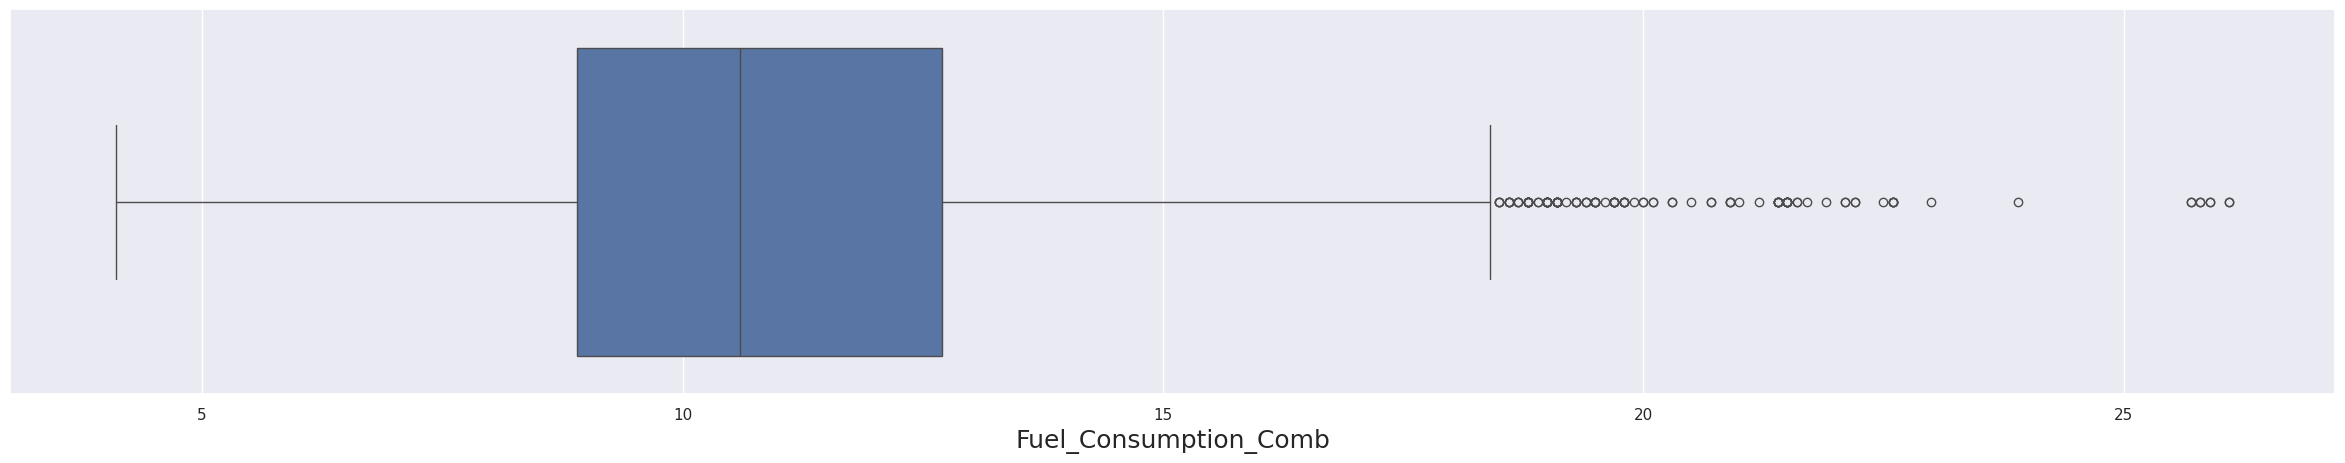

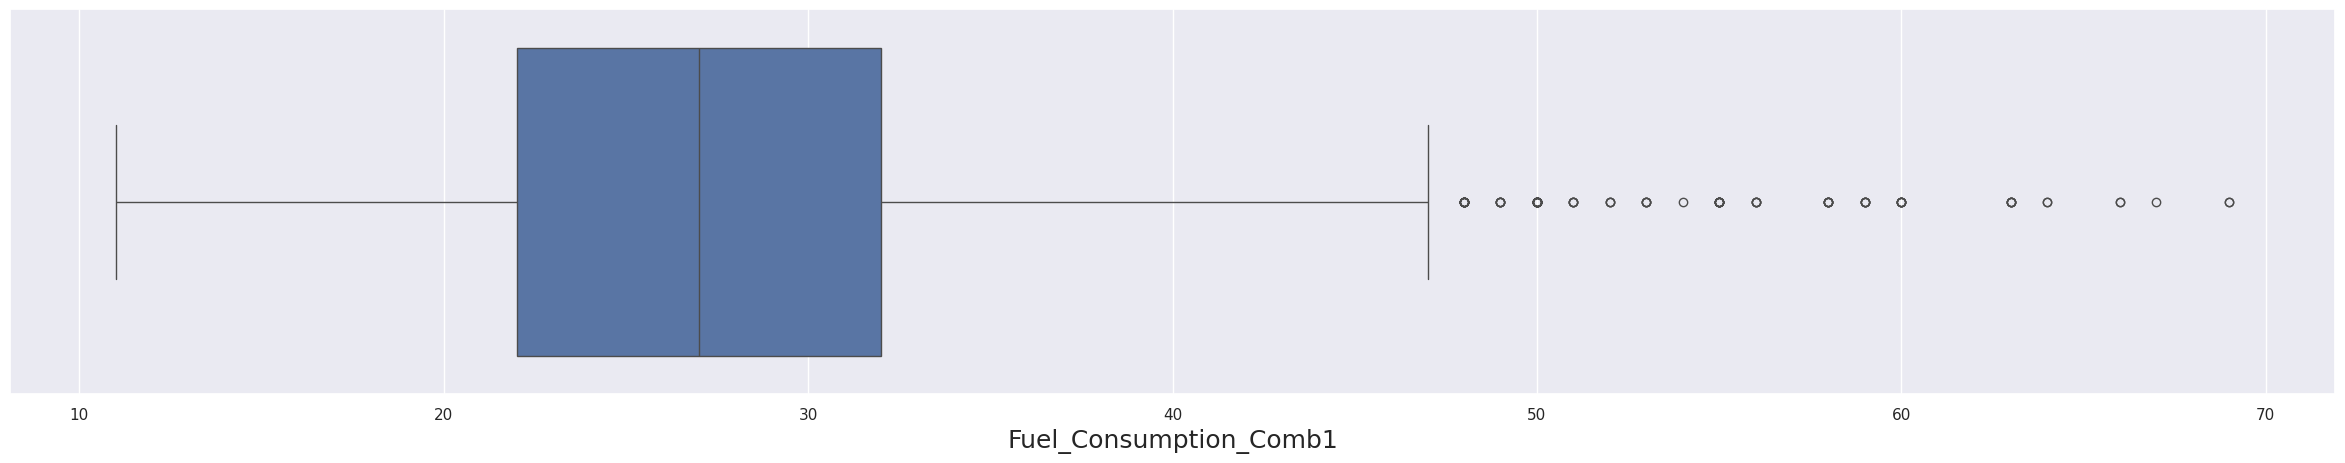

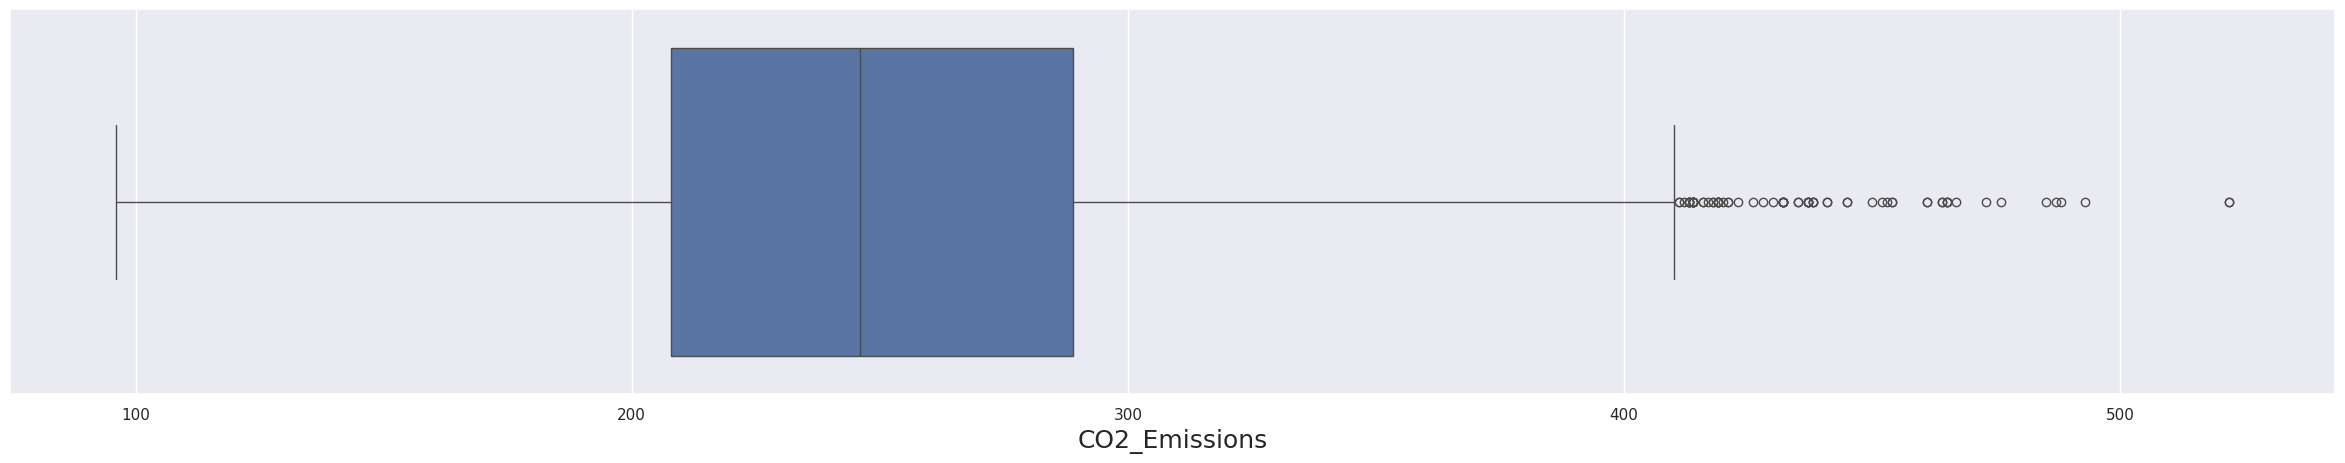

In [30]:
for column in enumerate(df_num_features):
    plt.figure(figsize=(30,5))
    sns.set_theme(style="darkgrid")
    sns.boxplot(x=column[1], data=  df_num_features)
    plt.xlabel(column[1],fontsize=18)
    plt.show()

In [31]:
stat, p_value = shapiro(df_num_features)

print('Test statistic:', stat)
print('P-Value:', p_value)

Test statistic: 0.5185014597911467
P-Value: 4.371807141727005e-137


In [32]:
df_num_features=data.select_dtypes(include=np.number)
Q1 = df_num_features.quantile(0.25)
Q3 = df_num_features.quantile(0.75)
IQR = Q3 - Q1

filtered_data = df_num_features[~((df_num_features < (Q1 - 1.5 * IQR)) | (df_num_features > (Q3 + 1.5 * IQR))).any(axis=1)]

filtered_indices = filtered_data.index

data = data.loc[filtered_indices]
data.reset_index(inplace=True, drop=True)

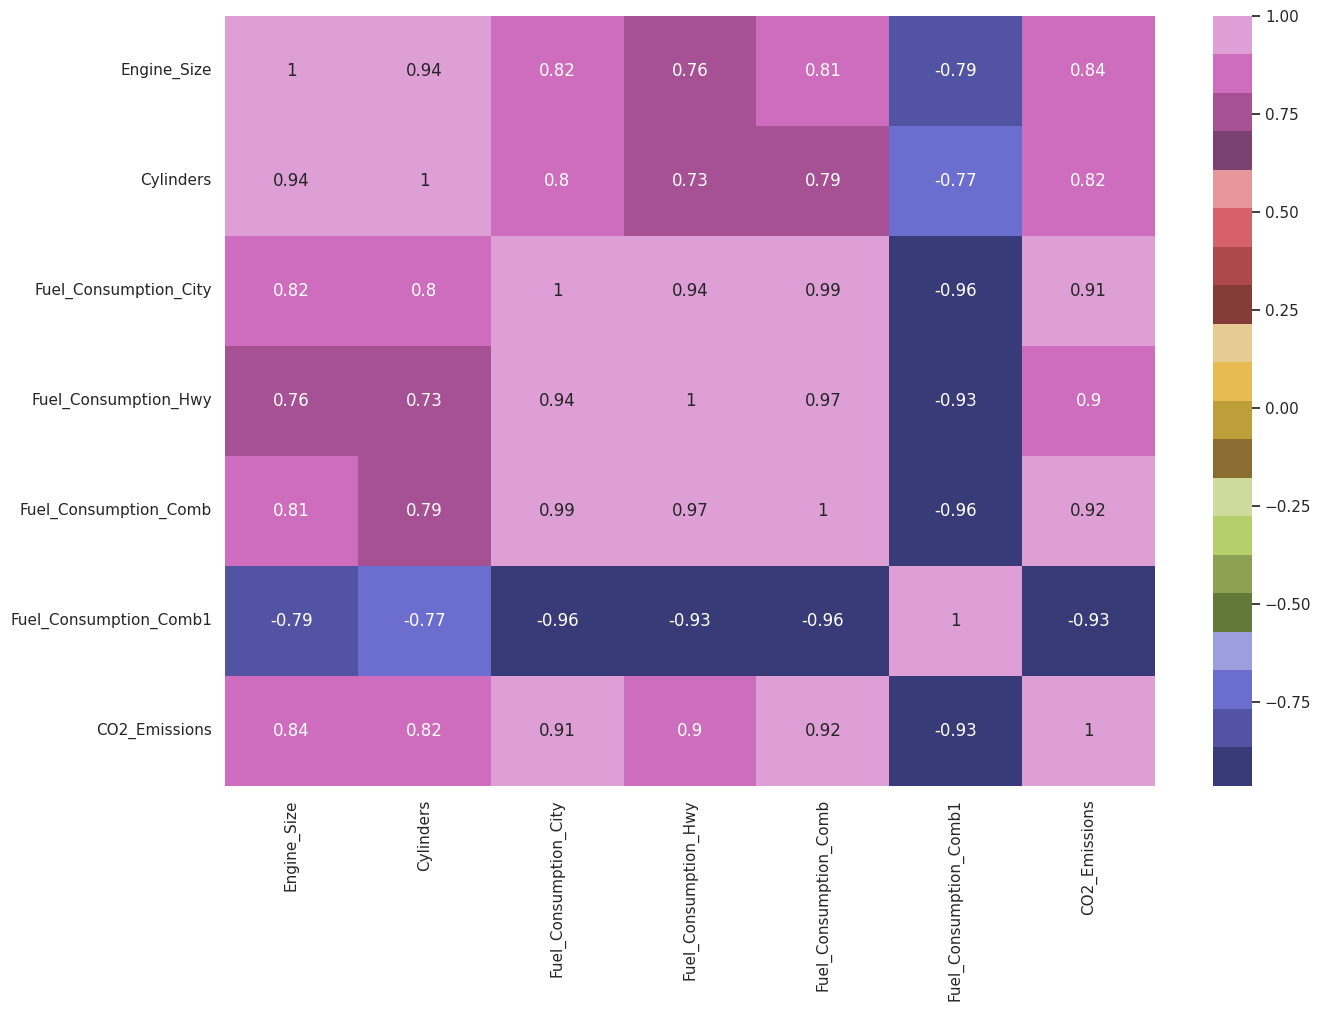

In [33]:
data_num_features = data.select_dtypes(include=np.number)

corr =  data_num_features.corr()

corr =data_num_features.corr(method='pearson')
sns.heatmap(corr, annot=True,cmap='tab20b')
plt.show()

In [34]:
df_dummies = pd.get_dummies(data = data[["Fuel_Type","Transmission","Make_Type","Vehicle_Class_Type"]], drop_first = True)

df_num_features=data.select_dtypes(include=np.number)

df_comb = pd.concat([df_num_features, df_dummies], axis = 1)

In [35]:
df_comb.head()

,Engine_Size,Cylinders,Fuel_Consumption_City,Fuel_Consumption_Hwy,Fuel_Consumption_Comb,Fuel_Consumption_Comb1,CO2_Emissions,Fuel_Type_E,Fuel_Type_N,Fuel_Type_X,Fuel_Type_Z,Transmission_A4,Transmission_A5,Transmission_A6,Transmission_A7,Transmission_A8,Transmission_A9,Transmission_AM5,Transmission_AM6,Transmission_AM7,Transmission_AM8,Transmission_AM9,Transmission_AS10,Transmission_AS4,Transmission_AS5,Transmission_AS6,Transmission_AS7,Transmission_AS8,Transmission_AS9,Transmission_AV,Transmission_AV10,Transmission_AV6,Transmission_AV7,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7,Make_Type_Luxury,Make_Type_Premium,Make_Type_Sports,Vehicle_Class_Type_SUV,Vehicle_Class_Type_Sedan,Vehicle_Class_Type_Truck
0,2.000000,4,9.900000,6.700000,8.500000,33,196,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,2.400000,4,11.200000,7.700000,9.600000,29,221,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False
2,3.500000,6,12.700000,9.100000,11.100000,25,255,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False
3,3.500000,6,12.100000,8.700000,10.600000,27,244,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False
4,3.500000,6,11.900000,7.700000,10.000000,28,230,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

X = df_comb.drop('CO2_Emissions', axis=1)
y = df_comb['CO2_Emissions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge_model = Ridge(alpha=0.5)
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = ridge_model.score(X_test, y_test)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 16.615256787108933
R-squared: 0.9933035751700711


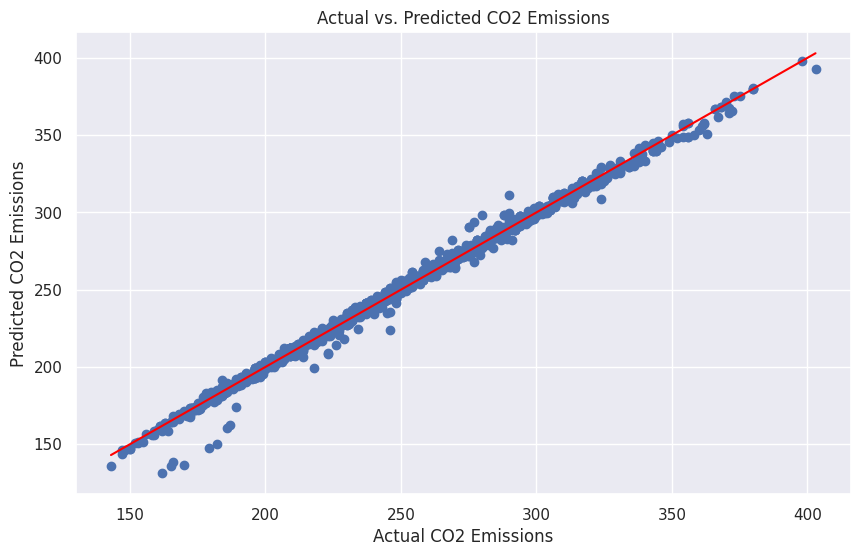

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual CO2 Emissions")
plt.ylabel("Predicted CO2 Emissions")
plt.title("Actual vs. Predicted CO2 Emissions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

In [38]:
import pickle

filename = 'ridge_model.pkl'
pickle.dump(ridge_model, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
